# Проект по прогнозированию оттока клиентов оператора связи «Ниединогоразрыва.ком»

## Задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно, подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import phik


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer

from phik import resources, report

from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier, plot_importance
from lightgbm import LGBMClassifier, Dataset

from tqdm import tqdm

from collections import defaultdict


Объявим константу RANDOM_STATE для воспроизводимости полученых результатов

In [2]:
RANDOM_STATE = 130323

Загрузим наши данные

In [3]:
try:
    contract_df = pd.read_csv('/content/drive/MyDrive/final_provider/contract.csv')
    internet_df = pd.read_csv('/content/drive/MyDrive/final_provider/internet.csv')
    personal_df = pd.read_csv('/content/drive/MyDrive/final_provider/personal.csv')
    phone_df = pd.read_csv('/content/drive/MyDrive/final_provider/phone.csv')
except FileNotFoundError:
    contract_df = pd.read_csv('contract.csv')
    internet_df = pd.read_csv('internet.csv')
    personal_df = pd.read_csv('personal.csv')
    phone_df = pd.read_csv('phone.csv')

## Предварительный исследовательский анализ данных

### Создадим функции для вывода информации о датасете

In [4]:
def min_eda_profiling(df, shape=True, dupl_number=True, head=True, other_inf=True):
    if shape == True:
        print(f'Размер датафрейма: {df.shape}\n')
    if dupl_number == True:
        print(f'Число полных дубликатов: {df.duplicated().sum()}\n')
    if head == True:
        print('Первые пять строк:')
        display(df.head())
    if other_inf == True:
        print('\nХарактеристики признаков (тип данных, количество пропусков в %, количество уникальных значений в %):')
        display(pd.concat([ 
            pd.DataFrame(df.dtypes, columns=['types']).T,
            pd.DataFrame((df.isna().sum()/df.shape[0]*100).round(2), columns=['na_perc']).T,
            pd.DataFrame(
                [round(df[col].unique().size/df.shape[0]*100, 2) for col in df.columns], 
                index=df.columns,
                columns=['uniq_perc']).T
                          ]))

In [5]:
def adv_eda_profiling(feature_series, feature_type='cat', change_dtype=False):
    if feature_type == 'cat':
        print(f'Характеристики признака:\n{feature_series.describe(datetime_is_numeric=True)}\n')
        print('Гистограмма')
        plt.figure(figsize=(10, 4), dpi=110)
        plt.hist(feature_series, 
                bins=len(feature_series.unique()),
                density=True, 
                rwidth=0.8,
                # align='left',
                color='g'
                )
        plt.grid(visible=True, color='r', linewidth=0.2)
        plt.xlabel('Категория', color='b')
        plt.ylabel('Плотность вероятности', color='b')
        plt.title('Распределение категорий в выборке', color='b', fontsize=15);

    elif feature_type == 'num':
        if change_dtype == True:
            feature_series = pd.to_numeric(feature_series)
        print(f'Первые 5 значений и тип данных:\n{feature_series[0:5]}\n')
        print(f'Характеристики признака:\n{feature_series.describe(datetime_is_numeric=True)}\n')
        print('Гистограмма')
        plt.figure(figsize=(10, 4), dpi=110)
        plt.hist(feature_series, 
                bins=30, 
                density=True, 
                rwidth=0.8,
                # align='left',
                color='g'
                )
        plt.grid(visible=True, color='r', linewidth=0.2)
        plt.xlabel('Значение', color='b')
        plt.ylabel('Плотность вероятности', color='b')
        plt.title('Распределение значений в выборке', color='b', fontsize=15)
        plt.show();
        print('\nДиаграмма размаха')
        pd.DataFrame(feature_series).boxplot()

    elif feature_type == 'date':
        if change_dtype == True:
            feature_series = pd.to_datetime(feature_series)
        print(f'Первые 5 значений и тип данных:\n{feature_series[0:5]}\n')
        print(f'Характеристики признака:\n{feature_series.describe(datetime_is_numeric=True)}\n')
        print('Гистограмма')
        plt.figure(figsize=(10, 4), dpi=110)
        plt.hist(feature_series, 
                bins=(feature_series.max().year * 12 + 
                      feature_series.max().month - 
                      feature_series.min().year * 12 - 
                      feature_series.min().month + 1), 
                density=True, 
                rwidth=0.8,
                # align='left',
                color='g'
                )
        plt.grid(visible=True, color='r', linewidth=0.2)
        plt.xticks(feature_series.value_counts().sort_index().index, rotation=90, fontsize=5)
        plt.xlabel('Дата', color='b')
        plt.ylabel('Плотность вероятности', color='b')
        plt.title('Распределение месяцев в выборке', color='b', fontsize=15);

### Выведем информацию о датасете contract_df

#### Выведем основную информацию

In [6]:
min_eda_profiling(contract_df)

Размер датафрейма: (7043, 8)

Число полных дубликатов: 0

Первые пять строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Характеристики признаков (тип данных, количество пропусков в %, количество уникальных значений в %):


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
types,object,object,object,object,object,object,float64,object
na_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uniq_perc,100.0,1.09,0.07,0.04,0.03,0.06,22.5,92.73


#### Результат изучения основной информации о датасете contract_df:

1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
2. Признаки 'BeginDate', 'EndDate', 'TotalCharges' имеют тип данных object. Следует изменить типы данных на соответствующие этим признакам. Признак 'EndDate' содержит строковые значения "No", которые в целях проекта предлагаю временно заменить на текущую дату.
3. В данных отсутствуют пропуски, однако так как большинство признаков имеют тип данных object не исключено, что пропуски заполнены заглушкой. Следует проверить данное предположение.
4. Из первых 5 строк и информации о количестве уникальных значений (низкий процент) мы делаем вывод о том, что признаки 'Type',	'PaperlessBilling',	'PaymentMethod' категориальные.
5. Смущает низкий процент уникальных значений в признаках 'BeginDate,	'EndDate'. Следует дополнительно изучить этот пункт и выявить причину. Тип данных в этих признаках должен быть datetime. 
6. Из первых 5 строк и информации о количестве уникальных значений (высокий процент) мы делаем вывод о том, что признаки 'MonthlyCharges',	'TotalCharges' количественные. Следует построить диаграммы разбросов и гистограммы распределения значений для данных признаков. Это позволит сделать выводы о наличии выбросов и аномалий.
7. Целевой признак необходимо сгенерировать на основании признака 'EndDate'.
8. На основании признаков 'BeginDate',	'EndDate' и текущей даты следует составить новый признак. Данный признак будет отображать информацию о количестве дней, которое клиент являлся/является пользователем услуг компании "Ниединогоразрыва.ком". На основании признака 'EndDate' можно проверить наличие сезонности оттока клиентов. Сами признаки 'BeginDate',	'EndDate' после этого нам не понадобятся.
9. Признак 'PaperlessBilling' кажется ненужным.

#### Выведем дополнительную информацию о датасете contract_df

##### Признак 'BeginDate'

Проверим изменяемость типа данных признака 'BeginDate'. Если тип данных не меняется:
  - возможно, в признаке имеются заглушки.
  - возможно, в признаке имеются артефакты.

Непосредственное изменение проведем при предобработке данных.

Первые 5 значений и тип данных:
0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

Характеристики признака:
count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

Гистограмма


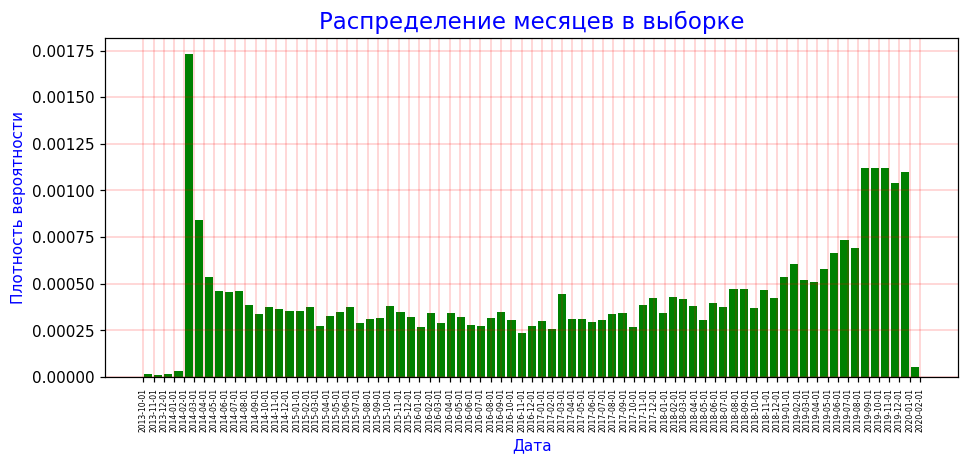

In [7]:
adv_eda_profiling(contract_df['BeginDate'], feature_type='date', change_dtype=True)

Тип данных изменился. Данные кажутся адекватными.

---



##### Признак 'EndDate'

Признак 'EndDate' содержит строковые значения No. Заменим их заглушкой. В качестве заглушки будет текущая дата.

Изменим тип данных. Если тип данных не меняется:
  - возможно, в признаке имеются другие заглушки.
  - возможно, в признаке имеются артефакты.

Непосредственное изменение проведем при предобработке данных.

In [8]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


Первые 5 значений и тип данных:
0   2023-10-01
1   2023-10-01
2   2019-12-01
3   2023-10-01
4   2019-11-01
Name: EndDate, dtype: datetime64[ns]

Характеристики признака:
count                             7043
mean     2022-09-20 11:22:53.448814336
min                2019-10-01 00:00:00
25%                2020-01-01 00:00:00
50%                2023-10-01 00:00:00
75%                2023-10-01 00:00:00
max                2023-10-01 00:00:00
Name: EndDate, dtype: object

Гистограмма


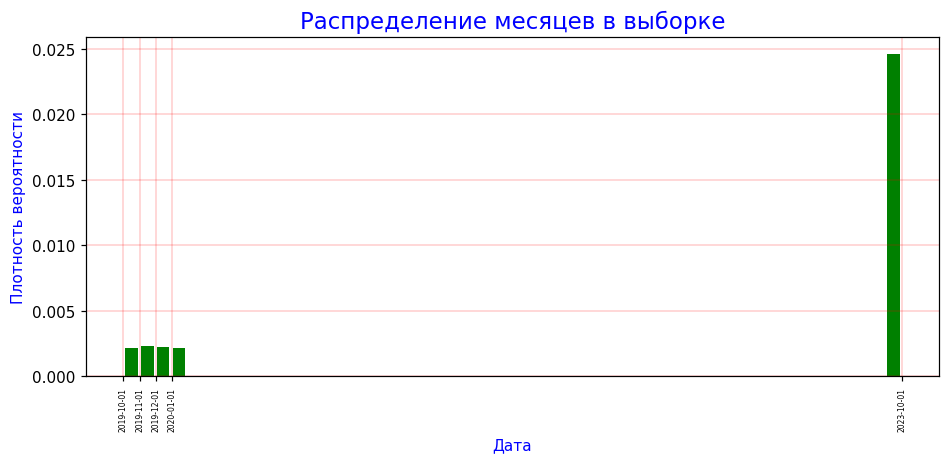

In [9]:
adv_eda_profiling(contract_df.replace('No', datetime.datetime.now().strftime("%Y-%m"))['EndDate'], 
                  feature_type='date', 
                  change_dtype=True)

Тип данных изменился. Смущает, что отток клиентов за все время работы компании происходил только в последние 4 месяца.

##### Признаки 'Type', 'PaperlessBilling', 'PaymentMethod'

Посмотрим на количество уникальных категорий и их дисбаланс в признаке.

In [10]:
for col in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    print(f'Уникальные значения признака {col}')
    print(contract_df[col].value_counts(), '\n')

Уникальные значения признака Type
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64 

Уникальные значения признака PaperlessBilling
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64 

Уникальные значения признака PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64 



В признаке отсутствуют заглушки. Данные выглядят адекватно.

##### Признак 'MonthlyCharges'

Первые 5 значений и тип данных:
0    29.85
1    56.95
2    53.85
3    42.30
4    70.70
Name: MonthlyCharges, dtype: float64

Характеристики признака:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Гистограмма


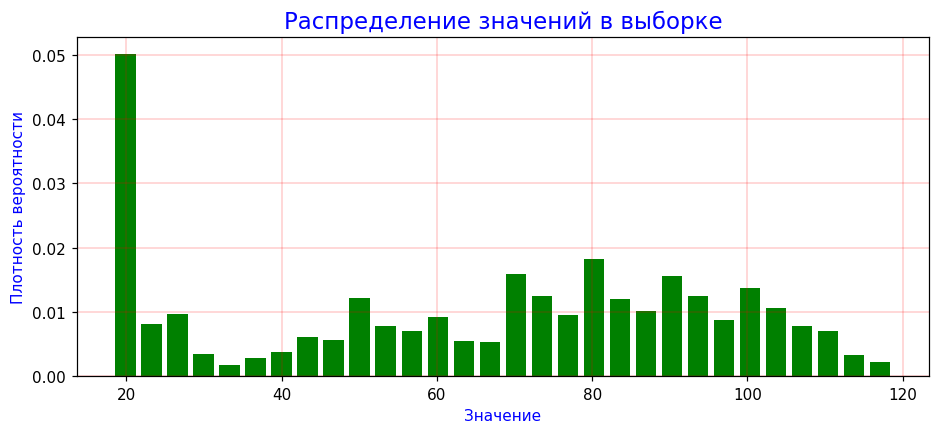


Диаграмма размаха


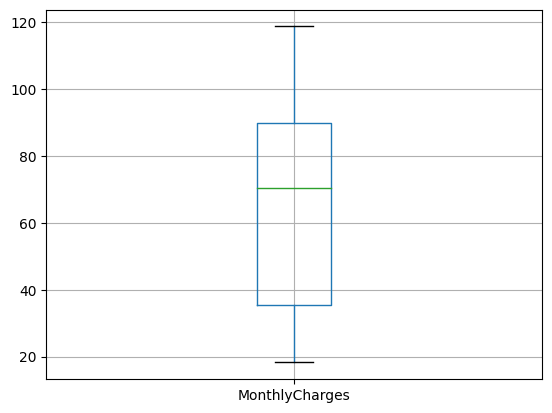

In [11]:
adv_eda_profiling(contract_df['MonthlyCharges'], feature_type='num')

Данные выглядят адекватно. Выбросов и аномалий нет.

##### Признак 'TotalCharges'

Попробуем узнать количество неявных пропусков в признаке 'TotalCharges'.

In [12]:
contract_df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).isna().sum()

11

In [13]:
contract_df[contract_df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Их всего 11 шт. Пропущенные данные только из последнего месяца. Возможно, это связанно с бесплатными первыми днями или у клиентов есть несколько дней на оплату.

Для целей предварительного исследовательского анализа можно от них избавиться. При предобработке данных можно заменить их на произведение 'MonthlyCharges' на количество месяцев из 'Type'. 

Первые 5 значений и тип данных:
0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

Характеристики признака:
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

Гистограмма


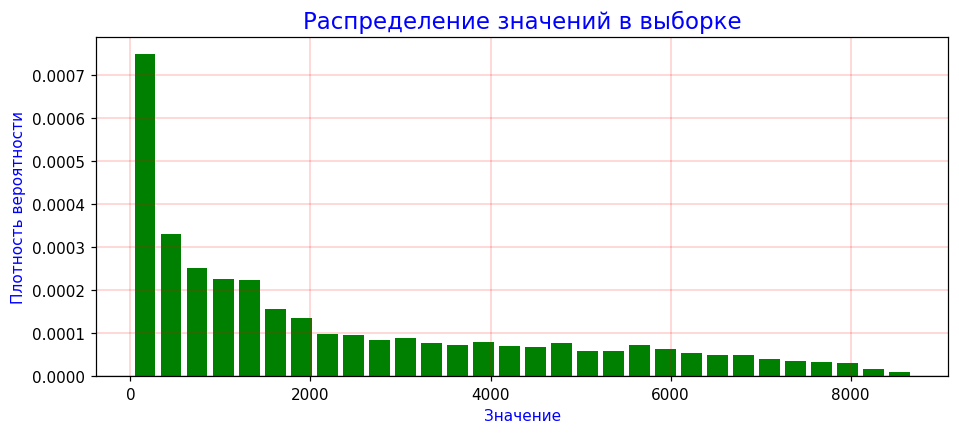


Диаграмма размаха


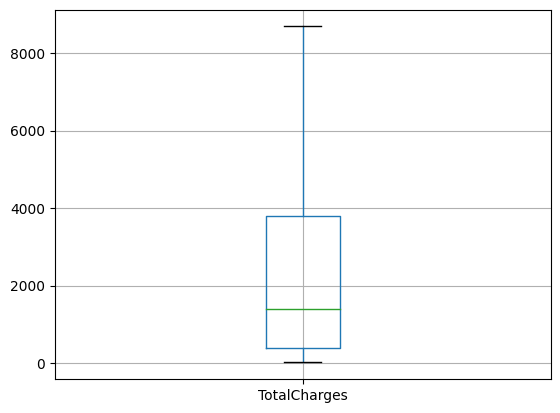

In [14]:
adv_eda_profiling(contract_df[~contract_df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).isna()]['TotalCharges'], 
                  feature_type='num', 
                  change_dtype=True)

Данные выглядят адекватно. Выбросов и аномалий нет.

### Выведем информацию о датасете internet_df

#### Выведем основную информацию

In [15]:
min_eda_profiling(internet_df)

Размер датафрейма: (5517, 8)

Число полных дубликатов: 0

Первые пять строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Характеристики признаков (тип данных, количество пропусков в %, количество уникальных значений в %):


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
types,object,object,object,object,object,object,object,object
na_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
uniq_perc,100.0,0.04,0.04,0.04,0.04,0.04,0.04,0.04


#### Результат изучения основной информации о датасете internet_df:

1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
2. Признаки 'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport', 'StreamingTV',	'StreamingMovies' являются категориальными и состоят только из двух классов.
3. В датасете отсутствуют пропуски. Возможные заглушки пропусков можно легко обнаружить, если вывести уникальные значения признаков.
4. Число объектов в датасете internet_df (5517) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признаков из датасета internet_df. Пропуски в этих объектах придется заполнять заглушкой.

#### Выведем дополнительную информацию по признаку датасета 'internet_df'

Посмотрим уникальные значения для всех признаков (все признаки  категориальные) и баланс классов.

In [16]:
for col in internet_df.columns[1:]:
    print(f'Уникальные значения признака {col}')
    print(internet_df[col].value_counts(), '\n')

Уникальные значения признака InternetService
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64 

Уникальные значения признака OnlineSecurity
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64 

Уникальные значения признака OnlineBackup
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64 

Уникальные значения признака DeviceProtection
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64 

Уникальные значения признака TechSupport
No     3473
Yes    2044
Name: TechSupport, dtype: int64 

Уникальные значения признака StreamingTV
No     2810
Yes    2707
Name: StreamingTV, dtype: int64 

Уникальные значения признака StreamingMovies
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64 



Заглушки отсутствуют. Данные выглядят адекватно.

### Выведем информацию о датасете personal_df

#### Выведем основную информацию

In [17]:
min_eda_profiling(personal_df)

Размер датафрейма: (7043, 5)

Число полных дубликатов: 0

Первые пять строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Характеристики признаков (тип данных, количество пропусков в %, количество уникальных значений в %):


,customerID,gender,SeniorCitizen,Partner,Dependents
types,object,object,int64,object,object
na_perc,0.0,0.0,0.0,0.0,0.0
uniq_perc,100.0,0.03,0.03,0.03,0.03


#### Результат изучения основной информации о датасете personal_df:

1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
2. Признаки 'gender',	'SeniorCitizen',	'Partner',	'Dependents' являются категориальными и состоят только из двух классов.
3. В датасете отсутствуют пропуски. Возможные заглушки пропусков можно легко обнаружить, если вывести уникальные значения признаков.
4. Число объектов в датасете personal_df (7043) равно числу объектов в датасете contract_df (7043). Если множества значений признаков customerID этих датасетов равны, то пропуски при объединении будут отсутствовать.

#### Выведем дополнительную информацию по признакам датасета 'personal_df'

In [18]:
for col in personal_df.columns[1:]:
    print(f'Уникальные значения признака {col}')
    print(personal_df[col].value_counts(), '\n')

Уникальные значения признака gender
Male      3555
Female    3488
Name: gender, dtype: int64 

Уникальные значения признака SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64 

Уникальные значения признака Partner
No     3641
Yes    3402
Name: Partner, dtype: int64 

Уникальные значения признака Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64 



Заглушки отсутствуют. Данные выглядят адекватно.

### Выведем информацию о датасете phone_df

#### Выведем основную информацию

In [19]:
min_eda_profiling(phone_df)

Размер датафрейма: (6361, 2)

Число полных дубликатов: 0

Первые пять строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Характеристики признаков (тип данных, количество пропусков в %, количество уникальных значений в %):


,customerID,MultipleLines
types,object,object
na_perc,0.0,0.0
uniq_perc,100.0,0.03


#### Результат изучения основной информации о датасете phone_df:

1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
2. Признак 'MultipleLines' является категориальными и состоит только из двух классов.
3. В датасете отсутствуют пропуски. Возможные заглушки пропусков можно легко обнаружить, если вывести уникальные значения признака.
4. Число объектов в датасете phone_df (6361) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признака 'MultipleLines'. Пропуски в этих объектах придется заполнять заглушкой.

#### Выведем дополнительную информацию по признаку 'MultipleLines'

In [20]:
print(f'Уникальные значения признака  MultipleLines')
print(phone_df['MultipleLines'].value_counts(), '\n')

Уникальные значения признака  MultipleLines
No     3390
Yes    2971
Name: MultipleLines, dtype: int64 



Заглушки отсутствуют. Данные выглядят адекватно.

#### Проверим совпадение ключей в разных датасетах

In [21]:
print('Количество ключей в датасетах internet_df, personal_df, phone_df которые отсутствуют в датасете contract_df:')
((~internet_df['customerID'].isin(contract_df['customerID'])).sum() +
 (~personal_df['customerID'].isin(contract_df['customerID'])).sum() +
 (~phone_df['customerID'].isin(contract_df['customerID'])).sum())

Количество ключей в датасетах internet_df, personal_df, phone_df которые отсутствуют в датасете contract_df:


0

### Вывод по результатам предварительного исследовательского анализа данных.

1. Результат изучения основной информации о датасете contract_df:
  1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
  2. Признаки 'BeginDate', 'EndDate', 'TotalCharges' имеют тип данных object. Следует изменить типы данных на соответствующие этим признакам. Признак 'EndDate' содержит строковые значения "No", которые в целях проекта предлагаю временно заменить на текущую дату.
  3. Пропуски в данных присутствуют только в признаке 'TotalCharges'. Их всего 11 шт. Пропущенные данные только из последнего месяца. Возможно, это связанно с бесплатными первыми днями или у клиентов есть несколько дней на оплату. При предобработке данных можно заменить их на произведение 'MonthlyCharges' на количество месяцев из 'Type'. 
  4. Признаки 'Type',	'PaperlessBilling',	'PaymentMethod' категориальные.
  5. Смущает, что отток клиентов ('EndDate') за все время работы компании происходил только в последние 4 месяца.
  6. Признаки 'MonthlyCharges',	'TotalCharges' количественные. Выбросы и аномалии отсутствуют.
  7. Целевой признак необходимо сгенерировать на основании признака 'EndDate' на этапе предобработки данных.
  8. На основании признаков 'BeginDate',	'EndDate' и последней актуальной даты следует составить новый признак. Данный признак будет отображать информацию о количестве дней, которое клиент являлся/является пользователем услуг компании "Ниединогоразрыва.ком". Сами признаки 'BeginDate',	'EndDate' после этого нам не понадобятся.


2. Результат изучения основной информации о датасете internet_df:
  1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
  2. Признаки 'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport', 'StreamingTV',	'StreamingMovies' являются категориальными и состоят только из двух классов.
  3. В датасете отсутствуют пропуски. 
  4. Число объектов в датасете internet_df (5517) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признаков из датасета internet_df. Пропуски в этих объектах придется заполнять заглушкой.


3. Результат изучения основной информации о датасете personal_df:
  1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
  2. Признаки 'gender',	'SeniorCitizen',	'Partner',	'Dependents' являются категориальными и состоят только из двух классов.
  3. В датасете отсутствуют пропуски.
  4. Пропуски при объединении с contract_df будут отсутствовать.


4. Результат изучения основной информации о датасете phone_df:
  1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
  2. Признак 'MultipleLines' является категориальными и состоит только из двух классов.
  3. В датасете отсутствуют пропуски. 
  4. Число объектов в датасете phone_df (6361) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признака 'MultipleLines'. Пропуски в этих объектах придется заполнять заглушкой.

## План работы

1. Создать объект предобработки данных с учетом выводов EDA. При создании объекта предобработки использовать ColumnTransformer. Категориальные признаки закодировать. Сгенерировать признаки упомянутые в EDA. Лишние удалить.
2. Подготовить тренировочную и тестовую выборки.
3. Определиться с используемыми метриками качества работы моделей. Скорее всего roc_auc.
4. Выбрать и обучить модели. При обучении использовать GSCV.
5. Лучшую модель проверить на тестовой выборке.

## Цель проекта
Cпрогнозировать отток клиентов. Метрика roc_auc

## Предобработка данных

На основании предварительного исследовательского анализа данных проведем предобработку.

### Создадим объект DataPreparer

Создадим объект, при помощи которого будем проводить предобработку данных. 
В дальнейшем будем использовать этот объект внутри pipeline при прогнозировании target на test выборке из сырых данных.

У такого подхода есть ряд плюсов:
- Мы можем быстро экспериментировать, удаляя признаки и считая метрику одним объектом pipeline 
- После обучения модели, при получении новых данных от «Ниединогоразрыва.ком», их полная обработка и получение предсказаний будут выполняться всего одним методом .predict()

In [22]:
class DataPreparer(BaseEstimator, TransformerMixin):
    def __init__(self, merge_on = 'customerID', 
                 fill_explicit_na_value = 'No', 
                 dict_dtype = {'customerID' : 'other',
                               'BeginDate' : 'date',
                               'EndDate' : 'date',
                               'Type' : 'cat',
                               'PaperlessBilling' : 'cat',
                               'PaymentMethod' : 'cat',
                               'MonthlyCharges' : 'num',
                               'TotalCharges' : 'num',
                               'InternetService' : 'cat',
                               'OnlineSecurity' : 'cat',
                               'OnlineBackup' : 'cat',
                                'DeviceProtection' : 'cat',
                               'TechSupport' : 'cat',
                                'StreamingTV' : 'cat',
                                'StreamingMovies' : 'cat',
                               'gender' : 'cat',
                               'SeniorCitizen' : 'cat',
                               'Partner' : 'cat',
                               'Dependents' : 'cat',
                               'MultipleLines' : 'cat',
                               'CustomerLeft' : 'cat'},
                 add_col_to_del = None): #
        self.merge_on = merge_on
        self.fill_explicit_na_value = fill_explicit_na_value
        self.dict_dtype = dict_dtype
        self.add_col_to_del = add_col_to_del #
        return None

    def merge(self, X, y = None):
        merged_df = X[0]
        for my_df in X[1:]:
            merged_df = merged_df.merge(my_df, how='left', on=self.merge_on)
        return merged_df

    def fill_explicit_na(self, X, y = None):
        return X.fillna(self.fill_explicit_na_value)

    def fill_implicit_na(self, X, y = None):
        type_dict = {'Month-to-month' : 1,
                     'Two year' : 24,
                     'One year' : 12}
        X = X.copy()
        X['TotalCharges'] = X['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)
        payment_type_num = X.loc[X['TotalCharges'].isna(), 'Type'].replace(type_dict)
        X.loc[X['TotalCharges'].isna(), 'TotalCharges'] = payment_type_num * \
            X.loc[X['TotalCharges'].isna(), 'MonthlyCharges']
        return X
        
    def generate_target(self, X, y = None):
        y = (X['EndDate'] != 'No').astype('int8')
        y = y.rename('CustomerLeft')
        return y

    def replace_values(self, X, y = None):
        X = X.copy()
        if (X['EndDate'] != 'No').any():
            X['EndDate'] = X['EndDate'].replace('No', 
                X.loc[X['EndDate'] != 'No', 'EndDate'].max())
            return X
        else:
            X['EndDate'] = X['EndDate'].replace('No', datetime.datetime.now().strftime("%Y-%m"))
            return X

    def change_dtypes(self, X, y = None):
        X = X.copy()
        for col in X.columns:
            if self.dict_dtype[col] == 'num':
                X[col] = pd.to_numeric(X[col])
            elif self.dict_dtype[col] == 'date':
                X[col] = pd.to_datetime(X[col])
            elif self.dict_dtype[col] == 'cat':
                X[col] = X[col].astype('category')
        return X

    def generate_feature(self, X, y = None):
        X = X.copy()
        X['CoopTermDays'] = (X['EndDate'] - X['BeginDate']).dt.days
        return X

    def del_features(self, X, y = None):
        if self.add_col_to_del == None:
            return X.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
        else:
            return X.drop(['customerID', 'BeginDate', 'EndDate'] + self.add_col_to_del, axis=1) #
        
    def fit(self, X = None, y = None):
        return self
        
    def transform(self, X, y = None):
        if isinstance(X, list):
            prepared_df = self.merge(X)
            prepared_df = self.fill_explicit_na(prepared_df)
            prepared_df = self.fill_implicit_na(prepared_df)
            prepared_df = self.replace_values(prepared_df)
            prepared_df = self.change_dtypes(prepared_df)
            prepared_df = self.generate_feature(prepared_df)
            prepared_df = self.del_features(prepared_df)
        return prepared_df

Создадим экземпляр класса

In [23]:
data_pr = DataPreparer()

### Объединим датасеты

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def merge(self, X, y = None):
        merged_df = X[0]
        for my_df in X[1:]:
            merged_df = merged_df.merge(my_df, how='left', on=self.merge_on)
        return merged_df

```

In [24]:
prepared_df = data_pr.merge([contract_df, internet_df, personal_df, phone_df])

Проверим результат:

In [25]:
prepared_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


Датасеты объединены

### Заполним явные пропуски

При объединении датасетов образовались пропуски. Эти пропуски должны быть заполнены значением 'No', так как отсутствие данных трактуется как отсутствие соответствующей услуги у пользователя

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def fill_explicit_na(self, X, y = None):
        return X.fillna(self.fill_explicit_na_value) #self.fill_explicit_na_value = 'No'

```

In [26]:
prepared_df = data_pr.fill_explicit_na(prepared_df)

Проверим датасет на наличие явных пропусков:

In [27]:
prepared_df.isna().any().any()

False

Пропуски заполнены

### Заполним неявные пропуски

Как следует из предварительного исследовательского анализа данных, признак 'TotalCharges' содержит неявные пропуски в виде строковых значений. Заполним их умножив количество месяцев из признака 'Type' на значение признака 'MonthlyCharges'

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def fill_implicit_na(self, X, y = None):
        type_dict = {'Month-to-month' : 1,
                     'Two year' : 24,
                     'One year' : 12}
        X = X.copy()
        X['TotalCharges'] = X['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)
        payment_type_num = X.loc[X['TotalCharges'].isna(), 'Type'].replace(type_dict)
        X.loc[X['TotalCharges'].isna(), 'TotalCharges'] = payment_type_num * \
            X.loc[X['TotalCharges'].isna(), 'MonthlyCharges']
```

In [28]:
prepared_df = data_pr.fill_implicit_na(prepared_df)

Проверим признак 'TotalCharges' на наличие неявных пропусков.

In [29]:
prepared_df['TotalCharges'].replace(r'^\s*$', np.nan, regex=True).isna().sum()

0

Неявные пропуски в признаке 'TotalCharges' отсутствуют.

### Сгенерируем целевой признак

Сгенерируем целевой признак из признака 'EndDate'

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def generate_target(self, X, y = None):
        y = (X['EndDate'] != 'No').astype('int8')
        y = y.rename('CustomerLeft')
        return y
```

In [30]:
target = data_pr.generate_target(prepared_df)

Проверим сгенерированный признак

In [31]:
target[:5]

0    0
1    0
2    1
3    0
4    1
Name: CustomerLeft, dtype: int8

Признак сгенерирован

### Избавимся от значений 'No' в признаке 'EndDate'

Заменим значения 'No' в признаке 'EndDate' на самую позднюю дату этого признака, либо при отсутствии дат в признаке на текущую дату.

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def replace_values(self, X, y = None):
        X = X.copy()
        if (X['EndDate'] != 'No').any():
            X['EndDate'] = X['EndDate'].replace('No', 
                X.loc[X['EndDate'] != 'No', 'EndDate'].max())
            return X
        else:
            X['EndDate'] = X['EndDate'].replace('No', datetime.datetime.now().strftime("%Y-%m"))
            return X
```

In [32]:
prepared_df = data_pr.replace_values(prepared_df)

Проверим наличие значения 'No' в признаке 'EndDate'

In [33]:
(prepared_df['EndDate'] == 'No').any()

False

Значения 'No' в признаке 'EndDate' заменены

### Изменим тип данных в признаках

Для дальнейшей работы с данными необходимо изменить их тип

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def change_dtypes(self, X, y = None):
        X = X.copy()
        for col in X.columns:
            if self.dict_dtype[col] == 'num':
                X[col] = pd.to_numeric(X[col])
            elif self.dict_dtype[col] == 'date':
                X[col] = pd.to_datetime(X[col])
        return X
```

In [34]:
prepared_df = data_pr.change_dtypes(prepared_df)

Проверим типы данных в признаках датасета

In [35]:
prepared_df.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                      category
PaperlessBilling          category
PaymentMethod             category
MonthlyCharges             float64
TotalCharges               float64
InternetService           category
OnlineSecurity            category
OnlineBackup              category
DeviceProtection          category
TechSupport               category
StreamingTV               category
StreamingMovies           category
gender                    category
SeniorCitizen             category
Partner                   category
Dependents                category
MultipleLines             category
dtype: object

Типы данных изменены

### Сгенерируем новый признак

Создадим новый признак 'CoopTermDays' - срок сотрудничества с пользователем в днях на основании признаков 'EndDate' и 'BeginDate'

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def generate_feature(self, X, y = None):
        X = X.copy()
        X['CoopTermDays'] = (X['EndDate'] - X['BeginDate']).dt.days
        return X
```

In [36]:
prepared_df = data_pr.generate_feature(prepared_df)

Проверим наличие созданного признака в датасете

In [37]:
prepared_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,CoopTermDays
0,7590-VHVEG,2020-01-01,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,0
1,5575-GNVDE,2017-04-01,2020-01-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1005
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,61


Признак присутствует. Значения адекватные.

### Удалим лишние признаки

Избавимся от признаков 'customerID', 'BeginDate', 'EndDate'

    Часть кода класса DataPreparer() для удобства проверки:
```python
    def del_features(self, X, y = None):
        if self.add_col_to_del == None:
            return X.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)
        # в случае если при инициализации объекту переданы дополнительные признаки
        else:
            return X.drop(['customerID', 'BeginDate', 'EndDate'] + self.add_col_to_del, axis=1)
```

In [38]:
prepared_df = data_pr.del_features(prepared_df)

Проверим результат

In [39]:
prepared_df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'CoopTermDays'],
      dtype='object')

Признаки удалены

### Масштабирование целевых признаков и кодирование категориальных.

Вторую часть предобработки данных вынесем в отдельный объект ColumnTransformer. Данный объект будет предан вместе с моделью в RandomizedSearchCV при помощи pipeline. Это важно, так как такая предобработка должна производится на train выборке каждого фолда при кросс-валидации. В противном случае мы будем иметь дело с утечкой данных.

Создадим этот объект:

In [40]:
quantitative_features = ['MonthlyCharges', 'TotalCharges', 'CoopTermDays']
categorical_features = [col for col in list(prepared_df.columns) if col not in quantitative_features]

In [41]:
column_trans = ColumnTransformer(
    [('numeric', StandardScaler(), quantitative_features),
     ('categories', OneHotEncoder(dtype='int8', handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough')

### Выводы по результатам предобработки данных.

В процессе предобработки данных было выполнено:
  1. Объединение датасетов.
  2. Заполнение явыных пропусков значением 'No'
  3. Заполнение неявных пропусков произведением 'MonthlyCharges' на количество месяцев из 'Type'
  4. Генерирование целевого признака 'CustomerLeft' на основе признака 'EndDate'
  5. Замена значений 'No' в признаке 'EndDate' для дальнейшей работы с признаком
  6. Изменение типов данных признаков
  7. Генерирование нового признака 'CoopTermDays' (количество дней, которое клиент являлся/является пользователем услуг) на основе признаков 'BeginDate', 'EndDate'
  8. Удаление лишних ('customerID', 'BeginDate', 'EndDate') признаков
  9. Создание объекта для дальнейшего масштабирования и кодирования признаков.

  По итогу предобработки были получены очищенные данные.

## Исследовательский анализ данных.

Основная часть исследовательского анализа данных была выполнена в разделе "Предварительный анализ данных". В данном разделе EDA будет дополнен:
- визуализацией очищенных признаков
- анализом очищенных признаков на мультиколлениарность
- проверкой целевого признака на дисбаланс

### Визуализация признаков

#### Визуализируем количественные признаки

Для количественных признаков построим гистограммы разброса значений и диаграммы размаха.

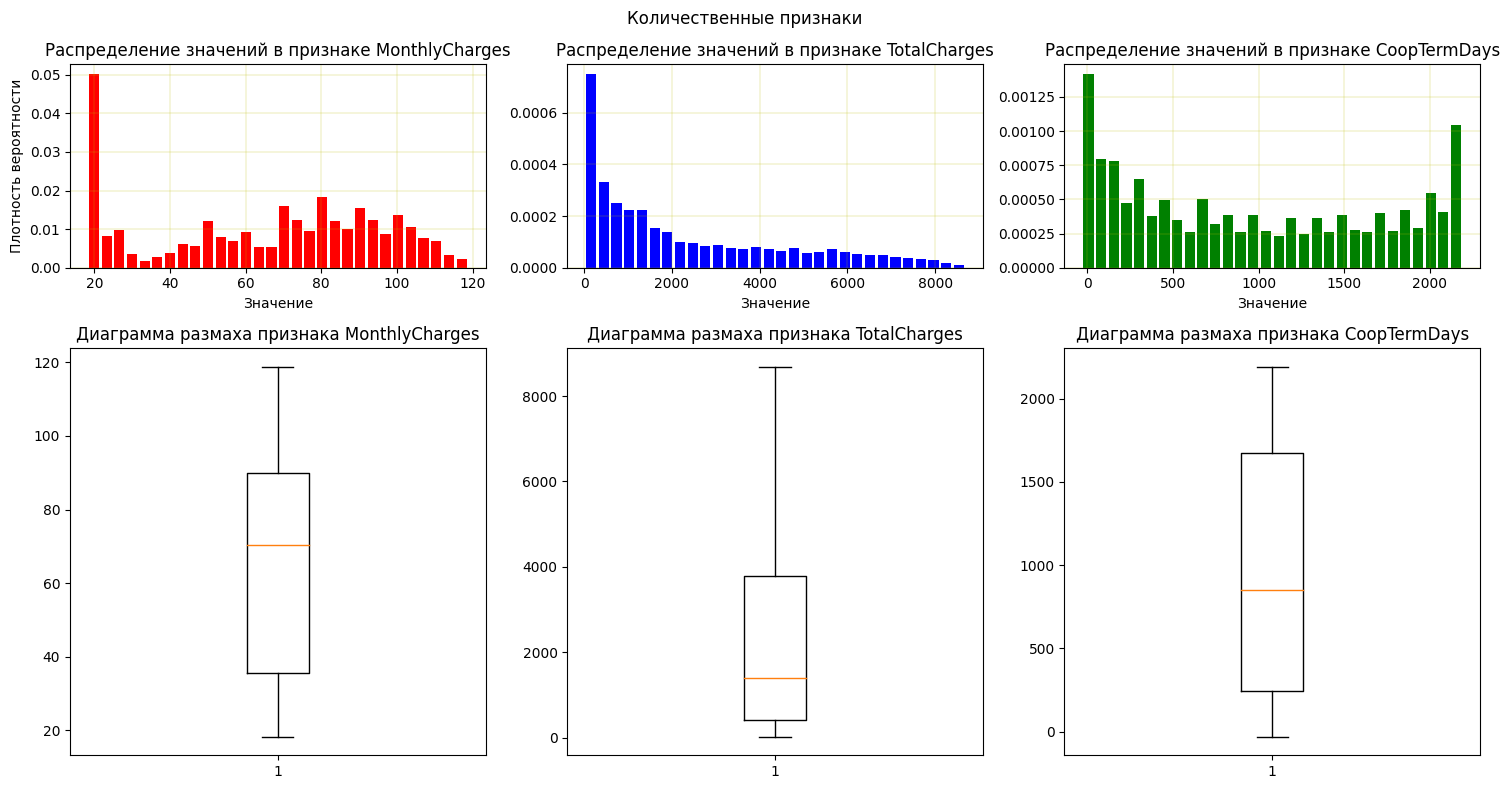

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), height_ratios=[10, 20], width_ratios=[7]*3)
fig.suptitle('Количественные признаки')
axes = ax.reshape(-1)
colors = ['r', 'b', 'g']
for i, col in enumerate(quantitative_features):
    axes[i].hist(prepared_df[col], 
                 bins=30, 
                 density=True, 
                 rwidth=0.8,
                 color=colors[i]
                 )
    axes[i].grid(visible=True, color='y', linewidth=0.2)
    axes[i].set_xlabel('Значение', color='k')
    if i == 0:
        axes[i].set_ylabel('Плотность вероятности', color='k')
    axes[i].set_title(f'Распределение значений в признаке {col}', color='k', fontsize=12)
    axes[i+3].boxplot(prepared_df[col])
    axes[i+3].set_title(f'Диаграмма размаха признака {col}', color='k', fontsize=12)
plt.tight_layout()
plt.show()

In [43]:
prepared_df[quantitative_features].describe()

,MonthlyCharges,TotalCharges,CoopTermDays
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2281.253259,963.222632
std,30.090047,2265.703526,742.870749
min,18.250000,18.800000,-31.000000
25%,35.500000,401.900000,245.000000
50%,70.350000,1396.250000,852.000000
75%,89.850000,3786.600000,1675.000000
max,118.750000,8684.800000,2191.000000


Количественные признаки выглядят адекватно, выбросы отсутствуют.

Из гистограммы, построенной для признака 'MonthlyCharges', видно насколько сильно выделяется первый столбец. Можно сделать вывод, что значительная часть клиентов пользуются каким-то минимальным/базовым пакетом услуг. Большинство других столбцов гистограммы не сильно отличаются друг от друга. Это говорит о том, что остальные пакеты услуг пользуются сопоставимой популярностью у клиентов. Выводы по конкретным услугам можно сделать, наблюдая баланс классов соответствующих признаков.

Похожую картину мы видим и на гистограмме признака 'TotalCharges'. Отчасти это связанно с тем же - значительная часть клиентов пользуются минимальным/базовым пакетом услуг. Однако свой вклад вносит и тот факт, что в последние дни наблюдается рекордный приток клиентов. Это хорошо видно на гистограмме признака 'CoopTermDays'. Естественно, что клиент, пришедший недавно, еще не успел заплатить компании много денег.

По гистограмме признака 'CoopTermDays' можно заключить, что значительный приток клиентов наблюдался не только в последние дни/месяцы, но и сразу после начала работы компании.

#### Визуализируем категориальные признаки

In [44]:
len(categorical_features)

15

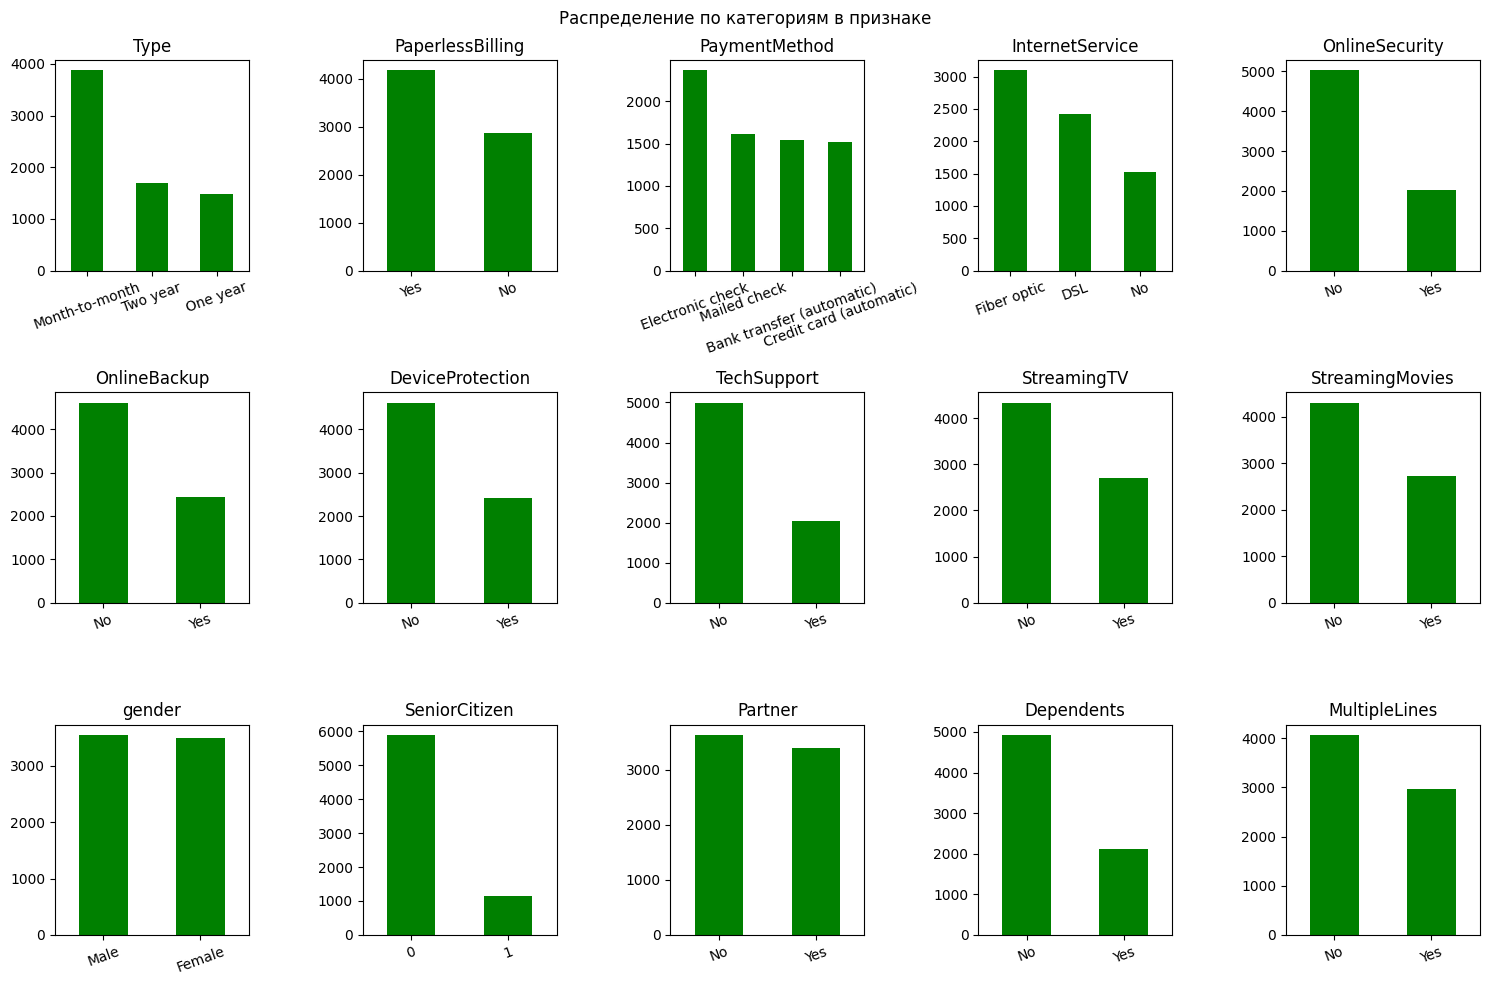

In [45]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
fig.suptitle('Распределение по категориям в признаке')
axes = ax.reshape(-1)
for i, col in enumerate(categorical_features):
    prepared_df[col].value_counts().plot(kind='bar',ax=axes[i], color='g')
    axes[i].set_title(col, color='k', fontsize=12)
    axes[i].tick_params(axis='x', labelrotation = 20)
plt.tight_layout()
plt.show()

Категориальные признаки выглядят адекватно

Отдельно проверим баланс классов для целевого признака.

На основании столбчатых графиков, можем сказать, что: 

    - большинство клиентов:    
        - оплачивают услуги раз в месяц
        - не пользуются бумажными счетами
        - оплачивают услуги электронно
        - предпочитают оптоволоконный интернет
        - не пользуются услугами: online security, online backup, device protection, tech support, streameng TV, streameng movies, multiple line
        - не являются пенсионерами
        - не имеют иждивенцев        
     - примерно равное количество клиентов:      
         - являются женщинами или мужчинами
         - состоят и не состоят в браке

По абсолютным значениям графиков можем сказать, что самые популярные услуги это streameng TV, streameng movies.

#### Проверка на дисбаланс классов

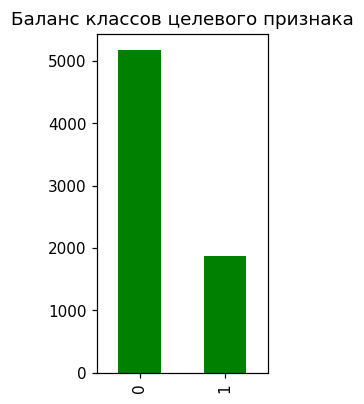

In [46]:
plt.figure(figsize=(2, 4), dpi=110)
target.value_counts().plot(kind='bar', color='g')
plt.title('Баланс классов целевого признака', color='k', fontsize=12)
plt.show()

Заметен существенный дисбаланс классов в целевом признаке. Дисбаланс классов целевого признака не сильно влияет на значение auc-roc, однако так как в дальнейшем дополнительно будет расчитываться метрика accuracy, то примем его во внимание. Для этого  при обучении моделей зададим параметр для его учета. Кроме того, разбивку на фолды при кросс-валидации будем проводить с учетом стратификации.

### Анализ признаков на мультиколлинеарность

Построим диаграмму рассеяния

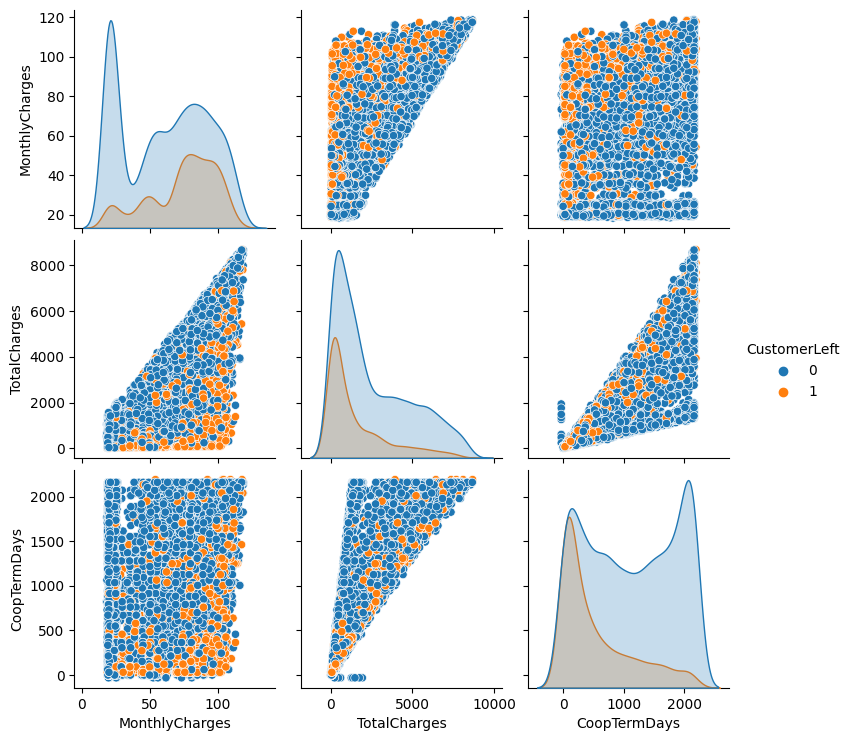

In [47]:
sns.pairplot(prepared_df[quantitative_features].join(target), hue='CustomerLeft');

На графиках видно, что
    
    - (график 1) если клиенты делают маленькие текущие платежы (возможно пользуются минимумом услуг) они чаще остаются чем уходят.
    - (график 2) существует прямая линейная зависимость между признаками MonthlyCharges и TotalCharges. При больших значених признака TotalCharges признак MonthlyCharges тоже имеет большие значения.
    - (график 3) отсутствует линейная зависимость между признаками MonthlyCharges и CoopTermDays. Следовательно со временем клиенты не начинают больше платить/пользоваться дополнительными или более дорогими услугами.
    - (график 6) Существует линейная зависимость между признаками TotalCharges и CoopTermDays. При больших значених признака TotalCharges признак CoopTermDays тоже имеет большие значения.
    - (график 9) большинство ушедших клиентов ушли в последние месяцы. Почти половина новых клиентов ушли.

#### Посмотрим на корреляцию Спирмена

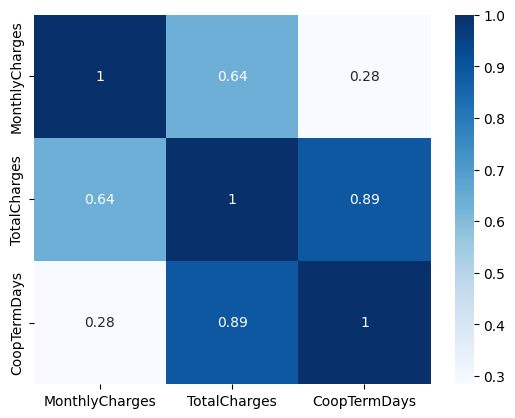

In [48]:
sns.heatmap(prepared_df[quantitative_features].corr(method='spearman'),cmap='Blues', annot=True);

#### Посмотрим на корреляцию φK

In [49]:
phik_matrix_df = prepared_df.join(target).phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'CoopTermDays', 'CustomerLeft']


Уберем значения 1 по диагонали

In [50]:
for i in phik_matrix_df.columns:
    phik_matrix_df.loc[i, i] = np.nan

Создадим последовательность признаков для которых кореляция φK больше 0,8

In [51]:
columns_high_corr_phik = (phik_matrix_df >= 0.8).any()[(phik_matrix_df >= 0.8).any()].index

Создадим матрицу состоящую только из этих признаков и только из значений выше 0,8. Добавим к ней целевой признак.

In [52]:
high_corr_phik = phik_matrix_df.loc[columns_high_corr_phik, columns_high_corr_phik].where(
    phik_matrix_df.loc[columns_high_corr_phik, columns_high_corr_phik] > .8, np.nan)

In [53]:
high_corr_phik = high_corr_phik.join(phik_matrix_df.loc[columns_high_corr_phik, 'CustomerLeft'])

Построим heatmap

In [54]:
high_corr_phik

,MonthlyCharges,TotalCharges,InternetService,StreamingTV,StreamingMovies,CoopTermDays,CustomerLeft
MonthlyCharges,NaN,NaN,0.919002,0.83534,0.833307,NaN,0.360050
TotalCharges,NaN,NaN,NaN,NaN,NaN,0.845683,0.280131
InternetService,0.919002,NaN,NaN,NaN,NaN,NaN,0.196202
StreamingTV,0.835340,NaN,NaN,NaN,NaN,NaN,0.096865
StreamingMovies,0.833307,NaN,NaN,NaN,NaN,NaN,0.093923
CoopTermDays,NaN,0.845683,NaN,NaN,NaN,NaN,0.453956


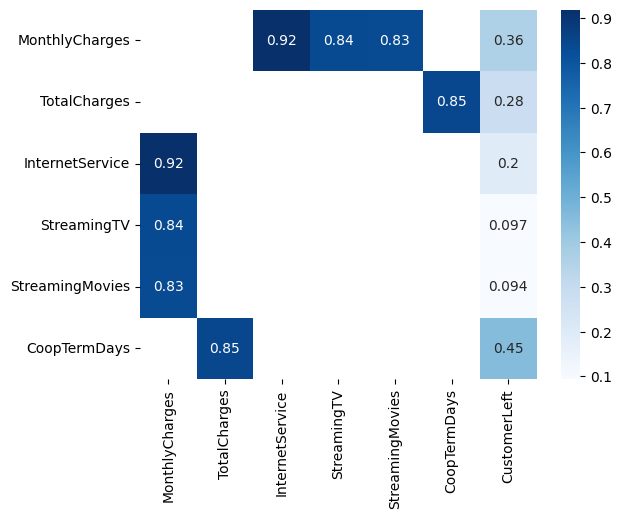

In [55]:
sns.heatmap(high_corr_phik,cmap='Blues', annot=True);

Судя по heatmap наблюдается высокая корреляция между признаком 'MonthlyCharges' и признаками InternetService	StreamingTV	StreamingMovies, а так же между признаком 'TotalCharges' и 'CoopTermDays'. 
Возможно, придется избавиться от части признаков. Чтобы узнать это обучим модели на всем датасете и на датасете без некоторых из этих признаков. Сравним результаты.


Избавляться лишних признаков можно при помощи нашего объекта DataPreparer.
Достаточно передать параметр в add_col_to_del при инициализации объекта список признаков, от которых мы собираемся избавиться.

### Выводы по результатам исследовательского анализа данных

- Значения в данных адекватные

- Значительная часть клиентов пользуются каким-то минимальным/базовым пакетом услуг. Остальные пакеты услуг пользуются примерно равной популярностью у клиентов. 
- В последние дни наблюдается рекордный приток клиентов. 
- Значительный приток клиентов наблюдался не только в последние дни/месяцы, но и сразу после начала работы компании.

- Большинство клиентов:    
    - оплачивают услуги раз в месяц
    - не пользуются бумажными счетами
    - оплачивают услуги электронно
    - предпочитают оптоволоконный интернет
    - не пользуются услугами: online security, online backup, device protection, tech support, streameng TV, streameng movies, multiple line
    - не являются пенсионерами
    - не имеют иждивенцев        
- Примерно равное количество клиентов:      
    - являются женщинами или мужчинами
    - состоят в браке
- Самые популярные дополнительные услуги это streameng TV, streameng movies.

- Заметен существенный дисбаланс классов в целевом признаке. Дисбаланс классов целевого признака не сильно влияет на значение auc-roc, однако так как в дальнейшем дополнительно будет расчитываться метрика accuracy, то примем его во внимание. Для этого при обучении моделей зададим параметр для его учета. Кроме того, разбивку на фолды при кросс-валидации будем проводить с учетом стратификации.

- В датасете наблюдается высокая корреляция между признаком 'MonthlyCharges' и признаками 'InternetService', 'StreamingTV', 'StreamingMovies', а так же между признаком 'TotalCharges' и 'CoopTermDays'. Как поступить с этими признаками решим при обучении модели.

- Судя по диаграмме расеяния: 
  - Если клиенты делают маленькие текущие платежы (возможно пользуются минимумом услуг) они чаще остаются чем уходят.
  - Существует прямая линейная зависимость между признаками MonthlyCharges и TotalCharges. При больших значених признака TotalCharges признак MonthlyCharges тоже имеет большие значения.
  - Отсутствует линейная зависимость между признаками MonthlyCharges и CoopTermDays. Следовательно со временем клиенты не начинают больше платить/пользоваться дополнительными или более дорогими услугами.
  - Существует линейная зависимость между признаками TotalCharges и CoopTermDays. При больших значених признака TotalCharges признак CoopTermDays тоже имеет большие значения.
  - Большинство ушедших клиентов ушли в последние месяцы. Почти половина новых клиентов ушли.

## Разбивка выборки 

Ранее в процессе выполнения проекта был создан объект для предобработки данных. Данный объект будет использован в одном pipeline вместе с RandomizedSearchCV. 
Мы можем передавать в pipeline "сырые" данные и получать обученную модель либо предсказания. Следовательно мы можем разбить на выборки сырые данные. Так как в процессе предобработки происходит объединение датасетов по "левому" датасету (contract_df - датасету с целевым признаком), для создания выборок достаточно разбить на выборки только датасет contract_df. Необходимые данные из других датасетов присоединятся в процессе предобработки внутри pipeline.
У данного метода есть несколько плюсов:
- Мы можем быстро экспериментировать, удаляя признаки и считая метрику одним объектом pipeline 
- При получении новых данных от «Ниединогоразрыва.ком», их обработка и получение предсказаний будут выполняться всего одним методом .predict()

Разобъем датасет contract_df на выборки

In [56]:
data_pr_obj = DataPreparer(add_col_to_del=['MonthlyCharges', 'TotalCharges'])

In [57]:
train_contract_df, test_contract_df = train_test_split(
    contract_df, test_size=.25, 
    stratify=data_pr_obj.generate_target(contract_df), 
    random_state=RANDOM_STATE, shuffle=True)

In [58]:
test_contract_df.shape[0] / contract_df.shape[0]

0.25003549623739885

In [59]:
train_contract_df.shape[0] / contract_df.shape[0]

0.7499645037626012

In [60]:
test_contract_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
515,9412-GHEEC,2016-08-01,2019-12-01 00:00:00,Month-to-month,No,Bank transfer (automatic),104.80,4131.95
4556,3750-CKVKH,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,67.75,116.65
822,7975-TZMLR,2016-03-01,No,One year,Yes,Electronic check,103.10,4889.3


In [61]:
train_contract_df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1164,4782-OSFXZ,2014-03-01,No,Two year,Yes,Bank transfer (automatic),82.70,5831.2
6050,0487-RPVUM,2015-01-01,No,Month-to-month,No,Bank transfer (automatic),99.40,5943.65
4073,7683-CBDKJ,2018-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,65.45,937.6


In [62]:
train_contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1164,4782-OSFXZ,2014-03-01,No,Two year,Yes,Bank transfer (automatic),82.70,5831.2
6050,0487-RPVUM,2015-01-01,No,Month-to-month,No,Bank transfer (automatic),99.40,5943.65
4073,7683-CBDKJ,2018-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,65.45,937.6
4426,8652-YHIYU,2018-10-01,No,One year,Yes,Credit card (automatic),79.50,1264.2
5924,2236-HILPA,2014-12-01,No,Two year,No,Credit card (automatic),20.65,1218.45
...,...,...,...,...,...,...,...,...
1140,9553-DLCLU,2019-01-01,No,Two year,No,Credit card (automatic),88.95,1161.75
28,5248-YGIJN,2014-02-01,No,Two year,Yes,Credit card (automatic),90.25,6369.45
3225,4931-TRZWN,2019-01-01,No,Month-to-month,Yes,Electronic check,71.95,923.85
1173,0107-WESLM,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,19.85,19.85


### Итог разбивки данных

Разбивка "сырых" данных проведена корректно

## Обучим модель

В цикле переберем разные варианты работы с признаками, выявленными в разделе Анализ признаков на мультуколлиниарность. По итогу работы цикла вернем словарь в который будут вложены:
  - Результаты работы разных моделей при CV для их сравнения
  - Обученные конвейеры с полным циклом предобработки данных и RandomizedSearchCV для дальнейшей работы с выборкой test
  - Отдельно сами обученные RandomizedSearchCV объекты для извлечения feature_importances_

In [64]:
clf1 = CatBoostClassifier(random_state=RANDOM_STATE)
clf2 = LGBMClassifier(random_state=RANDOM_STATE)
clf3 = LogisticRegression(random_state=RANDOM_STATE)

param1 = {}
param1['classifier__iterations'] = [200, 900]
param1['classifier__learning_rate'] = [0.5]
param1['classifier__max_depth'] = [5, 10]
param1['classifier__auto_class_weights'] = ['Balanced']
param1['classifier__verbose'] = [0]
param1['transformer__categories'] = ['passthrough']
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__learning_rate'] = [0.5]
param2['classifier__max_depth'] = [5, 10]
param2['classifier__verbose'] = [0]
param2['classifier__force_row_wise'] = ['True']
param2['classifier__class_weight'] = ['balanced']
param2['classifier__num_leaves'] = [10]
param2['transformer__categories'] = ['passthrough']
param2['classifier__num_threads'] = [1] #
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__class_weight'] : ['balanced']
param3['classifier'] = [clf3]

params = [param1, param2, param3]

prep_varian_dict = {}

for prep_variant in tqdm(['Признаки не удалены',
                          'Удалены признаки MC, TC',
                          'Удален признак TC',
                          'Удалены признаки IS, STV, SM, CTD',
                          'Удалены признаки IS, STV, SM']):

    if prep_variant == 'Признаки не удалены':
        data_pr_obj = DataPreparer()
        quantitative_features = ['MonthlyCharges', 'TotalCharges', 'CoopTermDays']
        categorical_features = [col for col in list(
            prepared_df.columns) if col not in quantitative_features]
        param1['classifier__cat_features'] = \
        [list(range(len(quantitative_features), 
                    len(quantitative_features + categorical_features)))]
    elif prep_variant == 'Удалены признаки MC, TC':
        data_pr_obj = DataPreparer(add_col_to_del=['MonthlyCharges', 'TotalCharges'])
        quantitative_features = ['CoopTermDays']
        categorical_features = [col for col in list(
            prepared_df.columns) if col not in quantitative_features \
            + ['MonthlyCharges', 'TotalCharges']]
        param1['classifier__cat_features'] = \
        [list(range(len(quantitative_features), 
                    len(quantitative_features + categorical_features)))]
    elif prep_variant == 'Удален признак TC':
        data_pr_obj = DataPreparer(add_col_to_del=['TotalCharges'])
        quantitative_features = ['MonthlyCharges', 'CoopTermDays']
        categorical_features = [col for col in list(
            prepared_df.columns) if col not in quantitative_features \
            + ['TotalCharges']]
        param1['classifier__cat_features'] = \
        [list(range(len(quantitative_features), 
                    len(quantitative_features + categorical_features)))]
    elif prep_variant == 'Удалены признаки IS, STV, SM, CTD':
        data_pr_obj = DataPreparer(add_col_to_del=['InternetService', 'StreamingTV', 
                                                   'StreamingMovies', 'CoopTermDays'])
        quantitative_features = ['MonthlyCharges', 'TotalCharges']
        categorical_features = [col for col in list(
            prepared_df.columns) if col not in quantitative_features \
            + ['InternetService', 'StreamingTV', 'StreamingMovies', 'CoopTermDays']]
        param1['classifier__cat_features'] = \
        [list(range(len(quantitative_features), 
                    len(quantitative_features + categorical_features)))]
    elif prep_variant == 'Удалены признаки IS, STV, SM':
        data_pr_obj = DataPreparer(add_col_to_del=['InternetService', 'StreamingTV', 
                                                   'StreamingMovies'])
        quantitative_features = ['MonthlyCharges', 'TotalCharges', 'CoopTermDays']
        categorical_features = [col for col in list(
            prepared_df.columns) if col not in quantitative_features \
            + ['InternetService', 'StreamingTV', 'StreamingMovies']]
        param1['classifier__cat_features'] = \
        [list(range(len(quantitative_features), 
                    len(quantitative_features + categorical_features)))]
    
    column_trans = ColumnTransformer(
        [('numeric', StandardScaler(), quantitative_features),
         ('categories', OneHotEncoder(dtype='int8', 
                                      handle_unknown='ignore', 
                                      drop='first', sparse_output=False), 
          categorical_features)
         ],
         remainder='passthrough').set_output(transform='pandas')

    model_pipe = Pipeline([('transformer', column_trans), ('classifier', clf1)])
    rsCV = RandomizedSearchCV(
        model_pipe, param_distributions=params, 
        scoring=['roc_auc', 'accuracy'],
        refit='roc_auc',
        cv=StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
    )

    prep_rsCV_pipe = make_pipeline(data_pr_obj, rsCV)
    prep_rsCV_pipe.fit([train_contract_df, internet_df, personal_df, phone_df], 
                       data_pr_obj.generate_target(train_contract_df))
    prep_varian_dict[prep_variant] = prep_rsCV_pipe

  0%|                                                                                                                                                                                           | 0/5 [00:00<?, ?it/s]/Users/zaurdzampaev/ml_projects/customer_churn_prediction/pvenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 20%|███████████████████████████████████▊                                                                                                                                               | 1/5 [00:45<03:00, 45.18s/it]/Users/zaurdzampaev/ml_projects/customer_churn_prediction/pvenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 40%|███████████████████████████████████████████████████████████████████████▌                                                                                                           | 2/5 [01:28<02:11, 43.89s/it]/Users/zaurdzampaev/ml_projects/customer_churn_prediction/pvenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 3/5 [02:14<01:29, 44.89s/it]/Users/zaurdzampaev/ml_projects/customer_churn_prediction/pvenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4/5 [02:59<00:45, 45.04s/it]/Users/zaurdzampaev/ml_projects/customer_churn_prediction/pvenv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:47<00:00, 45.46s/it]


Сведем для наглядности лучшие полученные метрики для разных вариантов предобработки в один датафрей.

In [65]:
dict_for_df = defaultdict(list)
for prep_v in prep_varian_dict:
    index = np.where(prep_varian_dict[prep_v]
                 ['randomizedsearchcv'].cv_results_['rank_test_roc_auc'] == 1)
    for clf in ('CatBoostClassifier', 'LGBMClassifier', 'LogisticRegression'):
        if clf in str(prep_varian_dict[prep_v]['randomizedsearchcv']
                      .best_estimator_['classifier']):
            dict_for_df[prep_v].extend([clf, 
                                        prep_varian_dict[prep_v][
                                            'randomizedsearchcv'].best_score_,
                                        prep_varian_dict[prep_v]\
                                        ['randomizedsearchcv']\
                                        .cv_results_['mean_test_accuracy'][index][0],
                                        prep_varian_dict[prep_v]\
                                        ['randomizedsearchcv']\
                                        .cv_results_['std_test_roc_auc'][index][0]])

In [66]:
pd.DataFrame(dict_for_df, index=['Лучшая модель', 'roc_auc_score', 'accuracy_score', 'std_roc_auc'])

,Признаки не удалены,"Удалены признаки MC, TC",Удален признак TC,"Удалены признаки IS, STV, SM, CTD","Удалены признаки IS, STV, SM"
Лучшая модель,LGBMClassifier,LGBMClassifier,LGBMClassifier,LogisticRegression,CatBoostClassifier
roc_auc_score,0.897511,0.86314,0.859344,0.828531,0.895561
accuracy_score,0.833016,0.789285,0.787959,0.790609,0.8493
std_roc_auc,0.00847,0.009621,0.007826,0.009468,0.00769


Как видим, удаление признаков с высокой коллинеарностью негативно сказывается на показателях метрик. Для дальнейшей работы выберем вариант предобработки данных, при котором признаки с высокой корреляцией удаляться не будут. Лучший оценщик при таком варианте предобработки данных - LGBMClassifier. 

Взглянем на гиперпараметры этого оценщика:

In [67]:
prep_varian_dict['Признаки не удалены']['randomizedsearchcv'].best_params_

{'transformer__categories': 'passthrough',
 'classifier__verbose': 0,
 'classifier__num_threads': 1,
 'classifier__num_leaves': 10,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.5,
 'classifier__force_row_wise': 'True',
 'classifier__class_weight': 'balanced',
 'classifier': LGBMClassifier(random_state=130323)}

Извлечем итоговую модель LGBMClassifier

In [68]:
prep_rsCV_pipe = prep_varian_dict['Признаки не удалены']

### Выводы по результатам обучения модели.

- удаление признаков с высокой коллинеарностью негативно сказывается на показателях метрик. Для дальнейшей работы выберем вариант предобработки данных, при котором признаки с высокой корреляцией удаляться не будут. 
- получена лучшая модель - LGBMClassifier.
- метрики модели:
```python
    'roc_auc_score' : 0.897544
    'accuracy_score' : 0.833016
    'std_roc_auc' : 0.008473
```
- параметры лучшей модели:
```python
    'classifier__verbose': 0,
    'classifier__num_leaves': 10,
    'classifier__max_depth': 5,
    'classifier__learning_rate': 0.5,
    'classifier__force_row_wise': 'True',
    'classifier__class_weight': 'balanced',
```
- Вся логика предобработки данных и обученная модель вложены в единый конвейер, что позволит при работе с реальными данными не проводить этапы очистки в каждой ячейке, а всего лишь передать "сырые" данные конвейеру.

## Проверим итоговую модель на тестовой выборке.

Создадим объект DataPreparer() без параметра add_col_to_del для очистки сырых данных без удаления признаков с высокой коллинеарностью.

In [69]:
data_pr_obj = DataPreparer()

Посчитаем метрику roc_auc методом .score()

In [70]:
prep_rsCV_pipe.score([test_contract_df, internet_df, personal_df, phone_df], 
                     data_pr_obj.generate_target(test_contract_df))

0.9144346001476094

Получим вероятности классов

In [71]:
predictions_proba = prep_rsCV_pipe.predict_proba([test_contract_df, internet_df, personal_df, phone_df])[:,1]

Посчитаем метрику roc_auc функцией roc_auc_score()

In [72]:
roc_auc_score(data_pr_obj.generate_target(test_contract_df), predictions_proba)

0.9144346001476094

Получили ожидаемый результат (тот же, что и методом .score() конвейера)

### Выводы по результатам работы модели на тестовой выборке

Значение метрики roc_auc на тестовой выборке сопоставимо со значением на тренировочной (на самом деле даже выше). Значение на тестовой выборке может быть выше, если закономерности выученные моделью более характерны для тестовой выборки.

## Проведем анализ важности признаков. 

Создадим объект Series с названиями признаков и значениями их важности

Занесем итоговый оценщик в отдельную переменную для удобства.

In [73]:
final_estimator = prep_varian_dict['Признаки не удалены']['randomizedsearchcv'].best_estimator_

Построим график важности признаков

In [74]:
feature_imp = pd.Series(final_estimator[1].feature_importances_, 
                        index= (final_estimator['transformer']
                                .transformers_[0][1].get_feature_names_out().tolist() \
                                + final_estimator['transformer']
                                .transformers_[1][2]))

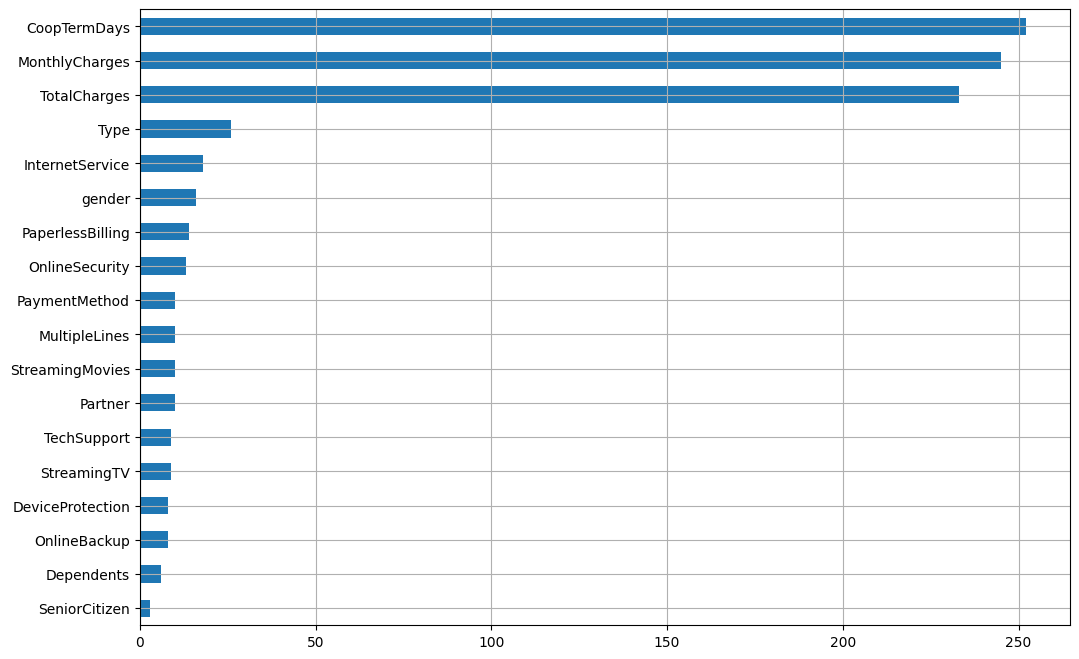

In [75]:
feature_imp.sort_values().plot.barh(figsize=(12,8), grid=True);

### Вывод по результатам анализа важности признаков

С отрывом наиболее важными признаками являются 'CoopTermDays', 'TotalCharges', 'MonthlyCharges'

## Матрица ошибок.

In [76]:
predictions = prep_rsCV_pipe.predict([test_contract_df, internet_df, personal_df, phone_df])

In [77]:
cf_matrix = confusion_matrix(data_pr_obj.generate_target(test_contract_df), predictions)

Создадим heatmap из матрицы ошибок для наглядности

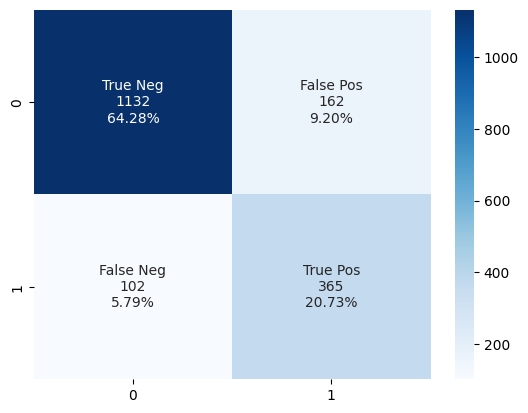

In [78]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

Модель точнее предсказывает класс 0, чем класс 1 (1132/162 > 365/102)

## Отчет:

### Развернутый отчет
1. Задача проекта:

    Задачей проекта было научиться прогнозировать отток клиентов на основе данных о некоторых клиентах, собранных командой оператора связи «Ниединогоразрыва.ком». По сути, задача бинарной классификации. На основе прогноза оператор планирует предлагать промокоды и специальные условия.
    Оценкой качества модели служила метрика auc_roc. Значение метрики менее 0,85 было принято, как не удовлетворительное.

2. В результате предварительного исследовательского анализа данных были изучены данные датасетов contract_df, internet_df, personal_df, phone_df

    1. Результат изучения основной информации о датасете contract_df:
        1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
        2. Признаки 'BeginDate', 'EndDate', 'TotalCharges' имеют тип данных object. Следует изменить типы данных на соответствующие этим признакам. Признак 'EndDate' содержит строковые значения "No", которые в целях проекта предложено временно заменить на текущую дату.
        3. Пропуски в датасете contract_df присутствуют только в признаке 'TotalCharges'. Их всего 11 шт. Пропущенные данные только из последнего месяца. Вероятно это связанно с бесплатными первыми днями или у клиентов есть несколько дней на оплату. Предложено заменить их при предобработке данных на произведение 'MonthlyCharges' на количество месяцев из 'Type'. 
        4. Признаки 'Type',	'PaperlessBilling',	'PaymentMethod' категориальные.
        5. Отток клиентов ('EndDate') за все время работы компании происходил только в последние 4 месяца.
        6. Признаки 'MonthlyCharges',	'TotalCharges' количественные. Выбросы и аномалии отсутствуют.
        7. Целевой признак предложено сгенерировать на основании признака 'EndDate' на этапе предобработки данных.
        8. На основании признаков 'BeginDate',	'EndDate' и последней актуальной даты предложено составить новый признак. Данный признак будет отображать информацию о количестве дней, которое клиент являлся/является пользователем услуг компании "Ниединогоразрыва.ком". Сами признаки 'BeginDate',	'EndDate' после этого нам не понадобятся.

    2. Результат изучения основной информации о датасете internet_df:
        1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
        2. Признаки 'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport', 'StreamingTV',	'StreamingMovies' являются категориальными и состоят только из двух классов.
        3. В датасете отсутствуют пропуски. 
        4. Число объектов в датасете internet_df (5517) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признаков из датасета internet_df. Пропуски в этих объектах придется заполнять заглушкой.

    3. Результат изучения основной информации о датасете personal_df:
        1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
        2. Признаки 'gender',	'SeniorCitizen',	'Partner',	'Dependents' являются категориальными и состоят только из двух классов.
        3. В датасете отсутствуют пропуски.
        4. Пропуски при объединении с contract_df будут отсутствовать.

    4. Результат изучения основной информации о датасете phone_df:
        1. Признак 'customerID' состоит только из уникальных значений и является ключом для объединения датасетов. После объединения он не понадобится.
        2. Признак 'MultipleLines' является категориальными и состоит только из двух классов.
        3. В датасете отсутствуют пропуски. 
        4. Число объектов в датасете phone_df (6361) значительно меньше, чем в датасете contract_df (7043). Следует уточнить причину отсутствия этих данных для части клиентов. Можно ли их получить? Если данные не доступны, то при объединении датасетов значительная часть объектов получит пропуски для признака 'MultipleLines'. Пропуски в этих объектах придется заполнять заглушкой.

3. В процессе предобработки данных было выполнено:

    1. Объединение датасетов.
    2. Заполнение явыных пропусков значением 'No'
    3. Заполнение неявных пропусков произведением 'MonthlyCharges' на количество месяцев из 'Type'
    4. Генерирование целевого признака 'CustomerLeft' на основе признака 'EndDate'
    5. Замена значений 'No' в признаке 'EndDate' для дальнейшей работы с признаком
    6. Изменение типов данных признаков
    7. Генерирование нового признака 'CoopTermDays' (количество дней, которое клиент являлся/является пользователем услуг) на основе признаков 'BeginDate', 'EndDate'
    8. Удаление лишних ('customerID', 'BeginDate', 'EndDate') признаков
    9. Создание объекта, который имеет необходимые методы для выполнения всех вышеперечисленных этапов, а так же может быть вложен в конвейер pipeline. Данный объект позволит:
        - быстро экспериментировать, удаляя признаки и считая метрику одним объектом pipeline 
        - после обучения модели, при получении новых данных от «Ниединогоразрыва.ком», выполнять их полную обработку и получение предсказаний всего одним методом .predict()
    10. Создание объекта для дальнейшего масштабирования и кодирования признаков при кросс-валидации

4. В результате окончательного исследовательского анализа данных были сделаны следующие выводы

    1. Значения в данных адекватные

    2. Значительная часть клиентов пользуются каким-то минимальным/базовым пакетом услуг. Остальные пакеты услуг пользуются примерно равной популярностью у клиентов. 
    3. В последние дни наблюдается рекордный приток клиентов. 
    4. Значительный приток клиентов наблюдался не только в последние дни/месяцы, но и сразу после начала работы компании.

    5. Большинство клиентов:    
        1. оплачивают услуги раз в месяц
        2. не пользуются бумажными счетами
        3. оплачивают услуги электронно
        4. предпочитают оптоволоконный интернет
        5. не пользуются услугами: online security, online backup, device protection, tech support, streaming TV, streaming movies, multiple line
        6. не являются пенсионерами
        7. не имеют иждивенцев        
    6. Примерно равное количество клиентов:      
        1. являются женщинами или мужчинами
        2. состоят в браке
    7. Самые популярные дополнительные услуги это streaming TV, streaming movies.

    8. Заметен существенный дисбаланс классов в целевом признаке. Дисбаланс классов целевого признака не сильно влияет на значение auc-roc, однако так как в дальнейшем дополнительно будет расчитываться метрика accuracy, то примем его во внимание. Для этого при обучении моделей зададим параметр для его учета. Кроме того, разбивку на фолды при кросс-валидации будем проводить с учетом стратификации.

    9. В датасете наблюдается высокая корреляция между признаком 'MonthlyCharges' и признаками 'InternetService', 'StreamingTV', 'StreamingMovies', а так же между признаком 'TotalCharges' и 'CoopTermDays'. Как поступить с этими признаками решим при обучении модели.

    10. Судя по диаграмме расеяния: 
        1. Если клиенты делают маленькие текущие платежы (возможно пользуются минимумом услуг) они чаще остаются чем уходят.
        2. Существует прямая линейная зависимость между признаками MonthlyCharges и TotalCharges. При больших значених признака TotalCharges признак MonthlyCharges тоже имеет большие значения.
        3. Отсутствует линейная зависимость между признаками MonthlyCharges и CoopTermDays. Следовательно со временем клиенты не начинают больше платить/пользоваться дополнительными или более дорогими услугами.
        4. Существует линейная зависимость между признаками TotalCharges и CoopTermDays. При больших значених признака TotalCharges признак CoopTermDays тоже имеет большие значения.
        5. Большинство ушедших клиентов ушли в последние месяцы. Почти половина новых клиентов ушли.

5. "Сырые" данные были разбиты на тренировочную и тестовую выборки.

6. В результате обучения модели пришли к следующему:

    1. Удаление признаков с высокой коллинеарностью негативно сказывается на показателях метрик. Для дальнейшей работы выбран вариант предобработки данных, при котором признаки с высокой корреляцией удаляться не будут. 
    2. Лучшая модель - LGBMClassifier.
    3. метрики модели:
```python
    'roc_auc_score' : 0.897544
    'accuracy_score' : 0.833016
    'std_roc_auc' : 0.008473
```
- параметры лучшей модели:
```python
    'classifier__verbose': 0,
    'classifier__num_leaves': 10,
    'classifier__max_depth': 5,
    'classifier__learning_rate': 0.5,
    'classifier__force_row_wise': 'True',
    'classifier__class_weight': 'balanced',
```
  
7. В результате работы модели с тестовой выборкой было получено значение метрики 

```python
    'roc_auc_score' : 0.914435
```

8. В результате анализа важности признаков было выявлено:
    
    С отрывом наиболее важными признаками являются 'CoopTermDays', 'TotalCharges', 'MonthlyCharges'

